# Agents:
These simulations evaluate several agents exploring the thread the needle enviroment

In [1]:
%load_ext autoreload
%autoreload 2
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
%matplotlib inline
import sys
import os
import torch
import numpy as np
import pandas as pd
from stable_baselines3 import PPO
import matplotlib.pyplot as plt
from datetime import date


from task.gridworld import CnnWrapper, ThreadTheNeedleEnv
from utils.config_utils import parse_task_config, load_config
from utils.pytorch_utils import DEVICE

print(f"python {sys.version}")
print(f"torch {torch.__version__}")
print(f"device = {DEVICE}")


python 3.10.11 (main, Apr 20 2023, 13:58:42) [Clang 14.0.6 ]
torch 2.0.1
device = mps


In [5]:
CONFIG_PATH = "configs"
TASK_CONFIG_FILE = "env_config.yml"
VAE_CONFIG_FILE = "vae_config.yml"
AGENT_CONFIG_FILE = "agent_config.yml"

TASK_NAME = "thread_the_needle"
MODEL_NAME = "cnn_vae"

TASK_CLASS = ThreadTheNeedleEnv

## Load Configs
task_config_file = os.path.join(CONFIG_PATH, TASK_CONFIG_FILE)
agent_config_file = os.path.join(CONFIG_PATH, AGENT_CONFIG_FILE)

env_kwargs = parse_task_config(TASK_NAME, task_config_file)
agent_config = load_config(agent_config_file)


SAVE_FILE_NAME = f"simulations/thread_the_needle_ppo_{date.today()}.csv"

In [6]:
env_kwargs = parse_task_config(TASK_NAME, task_config_file)


# create the task and get the optimal policy
task = CnnWrapper(TASK_CLASS.create_env(**env_kwargs))

pi, _ = task.get_optimal_policy()
# training_kwargs["optimal_policy"] = pi

  0%|          | 0/1000 [00:00<?, ?it/s]

<Axes: title={'center': 'Thread-the-needle states'}>

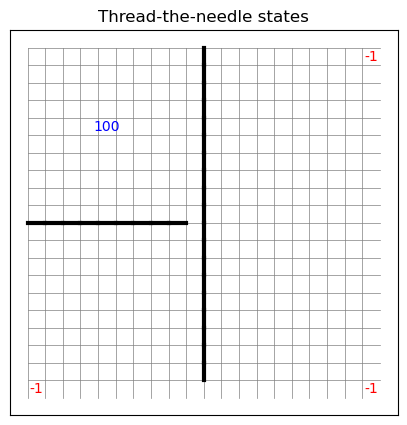

In [7]:
task.display_gridworld()

In [10]:
ppo = PPO("CnnPolicy", task, verbose=0)
ppo.learn(total_timesteps=agent_config["n_train_steps"], progress_bar=True)

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30,662/30,000  [ 0:02:46 < 0:00:00 , 232 it/s ]

In [11]:
from utils.training_utils import sample_policy

pi_hat, _ = sample_policy(
    ppo, n_states=env_kwargs["n_states"], map_height=env_kwargs["map_height"], cnn=True
)

Text(0.5, 1.0, 'right')

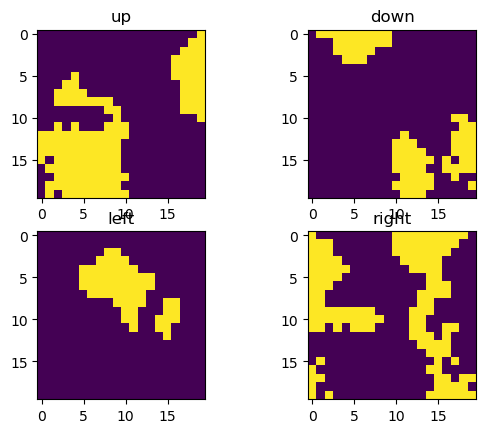

In [12]:
fig, axes = plt.subplots(2, 2)
h, w = env_kwargs["height"], env_kwargs["width"]
axes[0][0].imshow(pi_hat.reshape(h, w) == 0)
axes[0][1].imshow(pi_hat.reshape(h, w) == 1)
axes[1][0].imshow(pi_hat.reshape(h, w) == 2)
axes[1][1].imshow(pi_hat.reshape(h, w) == 3)


axes[0][0].set_title("up")
axes[0][1].set_title("down")
axes[1][0].set_title("left")
axes[1][1].set_title("right")

In [13]:
from utils.training_utils import (
    get_policy_prob,
    stable_baselines_get_pmf,
)


pmf = get_policy_prob(
    ppo,
    stable_baselines_get_pmf,
    n_states=env_kwargs["n_states"],
    map_height=env_kwargs["map_height"],
    cnn=True,
)

Text(0.5, 0.98, 'PPO Learned Policy')

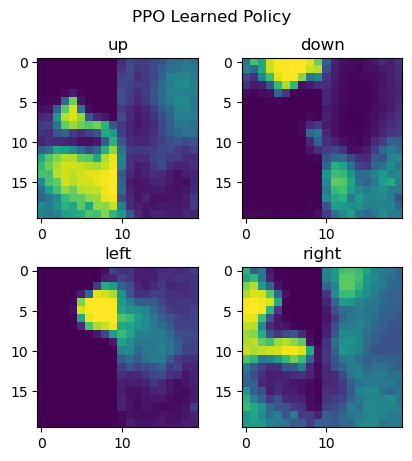

In [14]:
import seaborn as sns

fig, axes = plt.subplots(2, 2)

axes[0][0].imshow(pmf[:, 0].reshape(h, w))
axes[0][1].imshow(pmf[:, 1].reshape(h, w))
axes[1][0].imshow(pmf[:, 2].reshape(h, w))
axes[1][1].imshow(pmf[:, 3].reshape(h, w))


axes[0][0].set_title("up")
axes[0][1].set_title("down")
axes[1][0].set_title("left")
axes[1][1].set_title("right")

plt.subplots_adjust(hspace=0.3, wspace=-0.3)

plt.suptitle("PPO Learned Policy")

Text(0.5, 0.98, 'Optimal Policy')

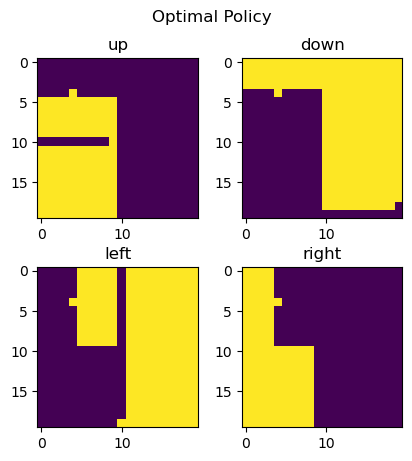

In [15]:
fig, axes = plt.subplots(2, 2)

axes[0][0].imshow(pi[:, 0].reshape(h, w))
axes[0][1].imshow(pi[:, 1].reshape(h, w))
axes[1][0].imshow(pi[:, 2].reshape(h, w))
axes[1][1].imshow(pi[:, 3].reshape(h, w))


axes[0][0].set_title("up")
axes[0][1].set_title("down")
axes[1][0].set_title("left")
axes[1][1].set_title("right")
plt.subplots_adjust(hspace=0.3, wspace=-0.3)

plt.suptitle("Optimal Policy")

In [16]:
np.sum(pi * pmf, axis=1).mean()

0.6656423240634518

In [17]:
from utils.training_utils import score_policy

score_policy(
    ppo,
    stable_baselines_get_pmf,
    pi,
    n_states=env_kwargs["n_states"],
    map_height=env_kwargs["map_height"],
    cnn=True,
)

0.6668408109568918

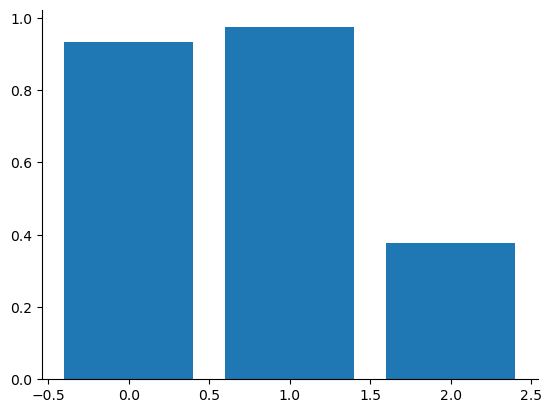

In [18]:
room_1_mask = (np.arange(400) < 200) * (np.arange(400) % 20 < 10)
room_2_mask = (np.arange(400) >= 200) * (np.arange(400) % 20 < 10)
room_3_mask = np.arange(400) % 20 >= 10

score_room_1 = np.sum(pi[room_1_mask] * pmf[room_1_mask], axis=1).mean()
score_room_2 = np.sum(pi[room_2_mask] * pmf[room_2_mask], axis=1).mean()
score_room_3 = np.sum(pi[room_3_mask] * pmf[room_3_mask], axis=1).mean()
plt.bar([0, 1, 2], [score_room_1, score_room_2, score_room_3])

sns.despine()

In [19]:
room_2_mask = (np.arange(400) >= 200) * (np.arange(400) % 20 < 10)

np.sum(pi[room_2_mask] * pmf[room_2_mask], axis=1).mean()

0.9741282042860985

In [20]:
np.sum(pi[room_3_mask] * pmf[room_3_mask], axis=1).mean()

0.3776016857335344

In [ ]:
from tqdm import trange

## Repeat with iterations
n_models = 8


room_1_mask = (np.arange(400) < 200) * (np.arange(400) % 20 < 10)
room_2_mask = (np.arange(400) >= 200) * (np.arange(400) % 20 < 10)
room_3_mask = np.arange(400) % 20 >= 10


scores = []


for idx in trange(n_models):
    ppo = PPO("CnnPolicy", task, verbose=0)
    ppo.learn(total_timesteps=agent_config["n_train_steps"], progress_bar=False)

    pmf = get_policy_prob(
        ppo,
        stable_baselines_get_pmf,
        n_states=env_kwargs["n_states"],
        map_height=env_kwargs["map_height"],
        cnn=True,
    )

    score_room_1 = np.sum(pi[room_1_mask] * pmf[room_1_mask], axis=1).mean()
    score_room_2 = np.sum(pi[room_2_mask] * pmf[room_2_mask], axis=1).mean()
    score_room_3 = np.sum(pi[room_3_mask] * pmf[room_3_mask], axis=1).mean()

    scores.append(
        pd.DataFrame(
            {
                "Iteration": [idx] * 4,
                "Score": [
                    np.sum(pi * pmf, axis=1).mean(),
                    score_room_1,
                    score_room_2,
                    score_room_3,
                ],
                "Condition": ["Overall", "Room 1", "Room 2", "Room 3"],
            }
        )
    )

scores = pd.concat(scores)

 12%|█████▌                                      | 1/8 [02:55<20:29, 175.58s/it]

In [ ]:
sns.catplot(data=scores, y="Score", x="Condition", kind="bar")

In [ ]:
scores["Environment"] = "Thread the needle"
scores.to_csv(SAVE_FILE_NAME)
scores2 = pd.read_csv("sims_thread_the_needle_no_walls.csv")
scores2["Environment"] = "No Walls"

all_scores = pd.concat([scores, scores2])
sns.catplot(
    data=all_scores[all_scores["Condition"] != "Overall"],
    y="Score",
    x="Condition",
    kind="point",
    hue="Environment",
)
plt.gca().set_ylim([0, 1])

In [ ]:
sns.catplot(
    data=all_scores[all_scores["Condition"] == "Overall"],
    y="Score",
    x="Environment",
    kind="bar",
)
plt.gca().set_ylim([0, 1])